In [28]:
import numpy as np, pandas as pd
#from sklearn.cluster import DBSCAN
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_distances
from sklearn.neighbors import KNeighborsClassifier

In [29]:
N_CAT = 30                     # number of places categories
WEIGHTS    = {"dislike": -3,
              "want to try": 1,
              "visited": 1,
              "fav": 2}
MIN_PLACES = 3                      # ignore users with <3 rated places
REDUCE_D   = 15                     # target dimension

In [30]:
# load embeddings 
places = pd.read_csv("places.csv") #import places csv
emb = np.stack(places['embedding'].apply(eval))

# compress for speed
pca_places = PCA(n_components=REDUCE_D, random_state=0).fit_transform(emb)

# perform clustering using KMeans technique
k30 = KMeans(N_CAT, random_state=0, n_init="auto").fit(pca_places)
places['cat_id'] = k30.labels_

In [ ]:
# pca = PCA(n_components=REDUCE_D).fit_transform
C = k30.cluster_centers_
D = cosine_distances(pca_places, C)
k = 3           
nearest = np.argsort(D, axis=1)[:, :k]

# explode into long form
rows = []
for pid, neigh in zip(places.place_id, nearest):
    for c in neigh:
        rows.append((pid, c))
place2cat = pd.DataFrame(rows, columns=["place_id", "cat_id"])

print(rows)
UP = pd.read_csv("user_place.csv").merge(place2cat, on="place_id")
UP['w'] = UP['status'].map(WEIGHTS)

U_mat = (UP
         .groupby(['user_id', 'cat_id']).w.sum()
         .unstack(fill_value=0)
         .astype(float))

# optional: drop sparse users
U_mat = U_mat[U_mat.abs().sum(1) >= MIN_PLACES]

# length-1 normalisation keeps cosine interpretable
U_vec = U_mat.div(np.linalg.norm(U_mat, axis=1), axis=0).fillna(0)


[('place_1', np.int64(4)), ('place_1', np.int64(27)), ('place_1', np.int64(11)), ('place_2', np.int64(4)), ('place_2', np.int64(1)), ('place_2', np.int64(11)), ('place_3', np.int64(12)), ('place_3', np.int64(13)), ('place_3', np.int64(1)), ('place_4', np.int64(8)), ('place_4', np.int64(1)), ('place_4', np.int64(23)), ('place_5', np.int64(7)), ('place_5', np.int64(19)), ('place_5', np.int64(2)), ('place_6', np.int64(2)), ('place_6', np.int64(14)), ('place_6', np.int64(3)), ('place_7', np.int64(19)), ('place_7', np.int64(7)), ('place_7', np.int64(2)), ('place_8', np.int64(7)), ('place_8', np.int64(2)), ('place_8', np.int64(19)), ('place_9', np.int64(7)), ('place_9', np.int64(2)), ('place_9', np.int64(19)), ('place_10', np.int64(2)), ('place_10', np.int64(19)), ('place_10', np.int64(7)), ('place_11', np.int64(7)), ('place_11', np.int64(2)), ('place_11', np.int64(19)), ('place_12', np.int64(7)), ('place_12', np.int64(2)), ('place_12', np.int64(19)), ('place_13', np.int64(2)), ('place_13', 

In [ ]:
# dim-reduce to dodge the curse of dimensionality
u_red = PCA(n_components=REDUCE_D, random_state=0).fit_transform(U_vec)

# scale so Euclidean distance is well-behaved
X = StandardScaler().fit_transform(u_red)

# run OPTICS
opt = OPTICS(min_samples=25, xi=0.05, min_cluster_size=0.02).fit(X)

U_vec['cluster'] = opt.labels_ 

In [ ]:
# def return_largest(row):
#     return row.T.nlargest(3).index.values

# if "testing" in U_vec.columns:
#     U_vec["testing"] = U_vec.drop("testing", axis = 1).apply(return_largest, axis=  1)
# else:
#     U_vec["testing"] = U_vec.apply(return_largest, axis=  1)
    

# print(U_vec["testing"])

print(U_mat)


cat_id       0     1     2     3     4     5     6     7     8     9   ...  \
user_id                                                                ...   
user_1      1.0   6.0   0.0   6.0   1.0   0.0   4.0   0.0   2.0   1.0  ...   
user_10     0.0   4.0   0.0   1.0   0.0   0.0   4.0   0.0   1.0   0.0  ...   
user_100    0.0  32.0  10.0  18.0  19.0   0.0   9.0   8.0   5.0   7.0  ...   
user_1000  25.0  48.0  99.0  91.0  41.0  19.0  62.0  95.0  44.0  21.0  ...   
user_1001  12.0  25.0  14.0  21.0  34.0   6.0  16.0  15.0   6.0  12.0  ...   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
user_995    6.0   1.0   0.0   4.0   9.0   0.0   1.0   1.0   0.0   2.0  ...   
user_996   13.0   4.0  17.0  35.0  27.0  23.0  23.0  13.0  10.0  12.0  ...   
user_997    1.0   4.0  10.0   2.0   1.0   1.0   1.0  11.0   2.0   2.0  ...   
user_998   28.0  11.0   2.0  23.0   8.0   1.0  17.0   3.0   4.0   1.0  ...   
user_999    2.0  11.0  13.0   2.0   3.0  11.0   3.0  12.0   4.0 

In [ ]:
def top_tags(cluster_id, n=8):
    user_ids = U_vec.index[U_vec.cluster == cluster_id]
    cats    = UP.loc[UP.user_id.isin(user_ids), 'cat_id']
    top_cats = cats.value_counts().head(3).index

    names = []
    for c in top_cats:
        # most common keywords for that place cluster
        kw = (places.loc[places.cat_id==c, 'key_words']
                .str.split().explode().value_counts().head(n).index)
        names.append(f"{c}: {'/'.join(kw)}")
    return " · ".join(names)

archetype_summary = (U_vec.cluster.value_counts()
                     .sort_index()
                     .rename_axis('cluster')
                     .to_frame('n_users'))

archetype_summary['vibe_snapshot'] = archetype_summary.index.map(top_tags)

pd.set_option('display.max_colwidth', None)   # or some large int

print(archetype_summary.head(10))


         n_users  \
cluster            
0           1271   

                                                                                                                                                                                                  vibe_snapshot  
cluster                                                                                                                                                                                                          
0        19: {"cocktail/with/{"wine/out/wine/decor"}/{speakeasy,"cocktail/up · 7: with/a/and/out/of/music/night/live · 1: night","special/with/decor"}/occasions","date/{"cocktail/seating"}/to/occasion","date  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

#  archetype features
#    (replace list(range(30)) with your actual column names if different)
feature_cols = list(range(30))
user_features_df = U_vec[feature_cols]

# 2) Keep track of user IDs in array form
user_ids = user_features_df.index.to_numpy()

# 3) Convert to a plain NumPy array
user_arr = user_features_df.to_numpy()     # shape: (n_users, 30)

# 4) Fit the NearestNeighbors model
nbrs = NearestNeighbors(n_neighbors=6, metric='cosine').fit(user_arr)


def get_user_neighbors(user_id, k=5):
    """
    Returns a DataFrame of the k nearest neighbors to user_id
    (by cosine distance on the 30-dim archetype vectors).
    """
    if user_id not in user_ids:
        raise KeyError(f"user_id {user_id} not found")

    # find the array index
    idx = np.where(user_ids == user_id)[0][0]

    # query k+1 so the first returned point is the user themself
    dists, idxs = nbrs.kneighbors(
        user_arr[idx].reshape(1, -1),
        n_neighbors=k+1
    )

    # drop the self-match
    neigh_idxs = idxs[0][1:]
    neigh_dists = dists[0][1:]
    neigh_ids   = user_ids[neigh_idxs]

    return pd.DataFrame({
        'neighbor_id': neigh_ids,
        'cosine_dist': neigh_dists
    })

# — example —
# for i in range(1,100):
#     print(get_user_neighbors(user_id='user_5', k=i))
    

# ─── 1) Prepare your feature matrix ───
# Assume `U_vec` is your DataFrame indexed by user_id with 30 numeric cols (0–29) + 'cluster'
feature_cols   = list(range(30))
user_features  = U_vec[feature_cols]
user_arr       = user_features.to_numpy()   # shape = (n_users, 30)

# ─── 2) Sweep k and compute RMSE ───
k_values = range(1, 21)   # try k=1..20
rmse_list = []

for k in k_values:
    # fit NN model (we ask for k+1 because the first neighbor is the point itself)
    nn = NearestNeighbors(n_neighbors=k+1, metric='cosine').fit(user_arr)
    dists, idxs = nn.kneighbors(user_arr)
    
    # drop self-indices (first column)
    neigh_idxs = idxs[:, 1:]
    
    # predict each user as the mean of its k neighbors
    preds = np.stack([user_arr[neigh_idxs[i]].mean(axis=0)
                      for i in range(user_arr.shape[0])])
    
    # compute RMSE over all users & all 30 dims
    mse  = np.mean((user_arr - preds)**2)
    rmse = np.sqrt(mse)
    rmse_list.append(rmse)

# ─── 3) Report results ───
results = pd.DataFrame({'k': k_values, 'rmse': rmse_list})
best = results.loc[results['rmse'].idxmin()]

print(f"▶ Best k = {best.k}, with RMSE = {best.rmse:.4f}")
print("\nAll results:")
print(results)

# ─── 4) (Optional) Plot RMSE vs k ───
plt.figure(figsize=(6,3))
plt.plot(results['k'], results['rmse'], marker='o')
plt.xlabel('k (number of neighbors)')
plt.ylabel('RMSE of reconstruction')
plt.title('Finding optimal k by RMSE')
plt.xticks(k_values)
plt.tight_layout()
plt.show() 

print(print(get_user_neighbors(user_id='user_7', k=7)))

import matplotlib.pyplot as plt

▶ Best k = 7.0, with RMSE = 0.0468

All results:
     k      rmse
0    1  0.058501
1    2  0.051043
2    3  0.048634
3    4  0.047626
4    5  0.047105
5    6  0.046894
6    7  0.046769
7    8  0.046809
8    9  0.047001
9   10  0.047101
10  11  0.047262
11  12  0.047439
12  13  0.047595
13  14  0.047817
14  15  0.047945
15  16  0.048171
16  17  0.048366
17  18  0.048556
18  19  0.048765
19  20  0.048960


AttributeError: module 'matplotlib' has no attribute 'figure'

In [ ]:
# ─── 0) Define stopwords ────────────────────────────────
STOPWORDS = {"with", "or", "and", "a", "the", "of", "to", "in"}

# ─── 1) Prepare your normalized feature matrix ───────────
feature_cols     = list(range(30))          # your 30 archetype columns
user_features_df = U_vec[feature_cols]
user_ids         = user_features_df.index.to_numpy()
user_arr         = user_features_df.to_numpy()

# ─── 2) Find each user’s top-7 nearest neighbors ─────────
# ask for 8 neighbors (self + 7) then drop the self‐match
nbrs = NearestNeighbors(n_neighbors=8, metric='cosine').fit(user_arr)
dists, idxs      = nbrs.kneighbors(user_arr)
neighbor_idxs    = idxs[:, 1:]     # shape (n_users, 7)
neighbor_dists   = dists[:, 1:]    # shape (n_users, 7)
neighbor_ids     = user_ids[neighbor_idxs]

# ─── 3) Gather keywords for “want to try”, “visited”, “fav” ─
statuses = ["want to try", "visited", "fav"]
vis = (
    UP[UP['status'].isin(statuses)]
      .merge(places[['place_id','key_words']], on='place_id', how='left')
)
vis['kw_clean'] = (
    vis['key_words']
       .fillna("")
       .astype(str)
       .str.replace(r'[\[\]\{\}"\']', "", regex=True)
)
def extract_words(s: str):
    parts = [part.strip() for part in s.split(',') if part.strip()]
    words = []
    for part in parts:
        part = re.sub(r'[^A-Za-z0-9\s]', "", part)
        for token in part.lower().split():
            if token and token not in STOPWORDS:
                words.append(token)
    return words

vis['words'] = vis['kw_clean'].apply(extract_words)

# ─── 4) Compute top-5 words per user ────────────────────
user_top5 = {}
for uid, grp in vis.groupby('user_id'):
    all_words = [w for sub in grp['words'] for w in sub]
    user_top5[uid] = [w for w,_ in Counter(all_words).most_common(5)]

# ─── 5) Print user_1 … user_20 with their top-5 + 7 neighbors ───
for i in range(1, 21):
    uid = f"user_{i}"
    if uid not in user_ids:
        print(f"{uid} not found\n" + "-"*60)
        continue

    idx = np.where(user_ids == uid)[0][0]
    print(f"User: {uid}")
    print(f"  User top-5 words: {user_top5.get(uid, [])}")

    for rank in range(7):
        nb   = neighbor_ids[idx, rank]
        dist = neighbor_dists[idx, rank]
        print(f"  {rank+1}. Neighbor: {nb}  (cosine dist={dist:.3f})")
        print(f"       Neighbor top-5 words: {user_top5.get(nb, [])}")

    print("-" * 60)


User: user_1
  User top-5 words: ['cafe', 'cozy', 'night', 'small', 'dinner']
  1. Neighbor: user_1003  (cosine dist=0.101)
       Neighbor top-5 words: ['cafe', 'date', 'pastries', 'night', 'coffee']
  2. Neighbor: user_400  (cosine dist=0.129)
       Neighbor top-5 words: ['cozy', 'cafe', 'night', 'pastries', 'date']
  3. Neighbor: user_58  (cosine dist=0.135)
       Neighbor top-5 words: ['cafe', 'date', 'night', 'pastries', 'cozy']
  4. Neighbor: user_474  (cosine dist=0.136)
       Neighbor top-5 words: ['night', 'date', 'cozy', 'authentic', 'lively']
  5. Neighbor: user_1151  (cosine dist=0.139)
       Neighbor top-5 words: ['cozy', 'italian', 'date', 'night', 'cafe']
  6. Neighbor: user_62  (cosine dist=0.149)
       Neighbor top-5 words: ['cozy', 'date', 'night', 'cafe', 'authentic']
  7. Neighbor: user_923  (cosine dist=0.157)
       Neighbor top-5 words: ['cozy', 'date', 'brunch', 'night', 'italian']
------------------------------------------------------------
User: user_2
  

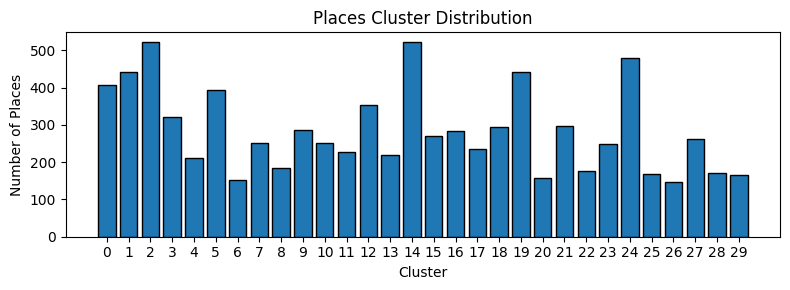

TypeError: loop of ufunc does not support argument 0 of type numpy.ndarray which has no callable sqrt method

In [ ]:
# ─── Sanity check ───
if 'U_vec' not in globals():
    raise RuntimeError("U_vec not found. Run your pipeline to build U_vec first.")
if 'cluster' not in U_vec.columns:
    raise RuntimeError("U_vec['cluster'] missing. Run OPTICS and assign U_vec['cluster']=opt.labels_.")

data = U_vec.drop(columns='cluster').values   # (n_users × 30)
labels = U_vec['cluster'].values

# 1) Bar chart of cluster sizes of places
unique, counts = np.unique(places["cat_id"], return_counts=True)
plt.figure(figsize=(8,3))
plt.bar(unique.astype(str), counts, edgecolor='black')
plt.title("Places Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Places")
plt.tight_layout()
plt.show()

# 2) Histogram of norms (should be at 1.0)
norms = np.linalg.norm(data, axis=1)
plt.figure(figsize=(6,3))
plt.hist(norms, bins=30, edgecolor='black')
plt.axvline(1.0, color='red', linestyle='--', label='Ideal = 1')
plt.title("Histogram of User Vector Norms")
plt.xlabel("‖user_vector‖")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# 3) Heatmap of normalized vectors (sorted by cluster)
order = np.argsort(labels)
sorted_data = data[order]

plt.figure(figsize=(10,4))
plt.imshow(sorted_data, aspect='auto', cmap='viridis')
plt.colorbar(label='Normalized Weight')
plt.title("Heatmap of User–Archetype Vectors (Users by Cluster)")
plt.xlabel("Archetype Category (0–29)")
plt.ylabel("Users (sorted by cluster)")
plt.tight_layout()
plt.show()

# 4) 2D PCA projection
pca2 = PCA(n_components=2, random_state=0)
proj = pca2.fit_transform(data)

plt.figure(figsize=(5,5))
scatter = plt.scatter(proj[:,0], proj[:,1],
                      c=labels, cmap='tab20', s=10, alpha=0.8)
plt.title("User Clusters (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()


0        4
1        4
2       12
3        8
4        7
        ..
8536    13
8537    29
8538    29
8539    29
8540    29
Name: cat_id, Length: 8541, dtype: int32
